# 神经网络的底层搭建
## 卷积模块
### 边界填充
<img src="20180425213940990.png" style="width:600px;height:400px;">

In [21]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
np.random.seed(1)

In [22]:
def zero_pad(X,pad):
    """
    把数据集X的图像边界全部使用0来扩充pad个宽度和高度。

    参数：
        X - 图像数据集，维度为（样本数，图像高度，图像宽度，图像通道数）
        pad - 整数，每个图像在垂直和水平维度上的填充量
    返回：
        X_paded - 扩充后的图像数据集，维度为（样本数，图像高度 + 2*pad，图像宽度 + 2*pad，图像通道数）

    """

    X_paded = np.pad(X,(
                        (0,0),       #样本数，不填充
                        (pad,pad),   #图像高度,你可以视为上面填充x个，下面填充y个(x,y)
                        (pad,pad),   #图像宽度,你可以视为左边填充x个，右边填充y个(x,y)
                        (0,0)),      #通道数，不填充
                        'constant', constant_values=0)      #连续一样的值填充

    return X_paded

Text(0.5, 1.0, 'x_paded')

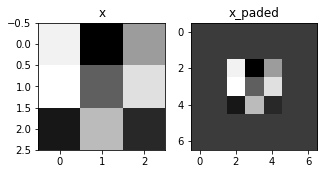

In [23]:
np.random.seed(1)
x = np.random.randn(4,3,3,2)
x_paded = zero_pad(x,2)

plt.figure()
plt.subplot(1,2,1)  #一行两列
plt.imshow(x[0,:,:,0])
plt.title('x')

plt.subplot(1,2,2)
plt.imshow(x_paded[0,:,:,0])
plt.title('x_paded')

### 单步卷积
<img src="20180425214517222.gif" style="width:600px;height:400px;">

In [24]:
def conv_single_step(a_slice_prev,W,b):
    """
    在前一层的激活输出的一个片段上应用一个由参数W定义的过滤器。
    这里切片大小和过滤器大小相同

    参数：
        a_slice_prev， 输入数据的一个片段，维度和一样
        W - 权重参数，包含在了一个矩阵中，维度为（过滤器大小，过滤器大小，上一通道数）
        b - 偏置参数，包含在了一个矩阵中，维度为（1,1,1）

    返回：
        Z - 在输入数据的片X上卷积滑动窗口（w，b）的结果。
    """

    s = np.multiply(a_slice_prev,W) + b

    Z = np.sum(s)

    return Z

### 前向卷积

$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{number of filters used in the convolution}$$

In [25]:
def conv_forward(A_prev, W, b, hparameters):
    """
    实现卷积函数的前向传播

    参数：
        A_prev - 上一层的激活输出矩阵，维度为(m, n_H_prev, n_W_prev, n_C_prev)，（样本数量，上一层图像的高度，上一层图像的宽度，上一层过滤器数量）
        W - 权重矩阵，维度为(f, f, n_C_prev, n_C)，（过滤器大小，过滤器大小，上一层的过滤器数量，这一层的过滤器数量）
        b - 偏置矩阵，维度为(1, 1, 1, n_C)，（1,1,1,这一层的过滤器数量）
        hparameters - 包含了"stride"与 "pad"的超参数字典。

    返回：
        Z - 卷积输出，维度为(m, n_H, n_W, n_C)，（样本数，图像的高度，图像的宽度，过滤器数量）
        cache - 缓存了一些反向传播函数conv_backward()需要的一些数据
    """

    #获取来自上一层数据的基本信息
    (m , n_H_prev , n_W_prev , n_C_prev) = A_prev.shape

    #获取权重矩阵的基本信息
    ( f , f ,n_C_prev , n_C ) = W.shape

    #获取超参数hparameters的值
    stride = hparameters["stride"]
    pad = hparameters["pad"]

    #计算卷积后的图像的宽度高度，参考上面的公式，使用int()来进行板除
    n_H = int(( n_H_prev - f + 2 * pad )/ stride) + 1
    n_W = int(( n_W_prev - f + 2 * pad )/ stride) + 1

    #使用0来初始化卷积输出Z
    Z = np.zeros((m,n_H,n_W,n_C))

    #通过A_prev创建填充过了的A_prev_pad
    A_prev_pad = zero_pad(A_prev,pad)

    for i in range(m):                              #遍历样本
        a_prev_pad = A_prev_pad[i]                  #选择第i个样本的扩充后的激活矩阵
        for h in range(n_H):                        #在输出的垂直轴上循环
            for w in range(n_W):                    #在输出的水平轴上循环
                for c in range(n_C):                #循环遍历输出的通道
                    #定位当前的切片位置
                    vert_start = h * stride         #竖向，开始的位置
                    vert_end = vert_start + f       #竖向，结束的位置
                    horiz_start = w * stride        #横向，开始的位置
                    horiz_end = horiz_start + f     #横向，结束的位置
                    #切片位置定位好了我们就把它取出来,需要注意的是我们是“穿透”取出来的，
                    #自行脑补一下吸管插入一层层的橡皮泥就明白了
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    #执行单步卷积
                    Z[i,h,w,c] = conv_single_step(a_slice_prev,W[: ,: ,: ,c],b[0,0,0,c])

    #数据处理完毕，验证数据格式是否正确
    assert(Z.shape == (m , n_H , n_W , n_C ))

    #存储一些缓存值，以便于反向传播使用
    cache = (A_prev,W,b,hparameters)

    return (Z , cache)

## 池化层
在同一个函数中实现最大值池化层和均值池化层，

In [26]:
def pool_forward(A_prev,hparameters,mode="max"):
    """
    实现池化层的前向传播

    参数：
        A_prev - 输入数据，维度为(m, n_H_prev, n_W_prev, n_C_prev)
        hparameters - 包含了 "f" 和 "stride"的超参数字典
        mode - 模式选择【"max" | "average"】

    返回：
        A - 池化层的输出，维度为 (m, n_H, n_W, n_C)
        cache - 存储了一些反向传播需要用到的值，包含了输入和超参数的字典。
    """

    #获取输入数据的基本信息
    (m , n_H_prev , n_W_prev , n_C_prev) = A_prev.shape

    #获取超参数的信息
    f = hparameters["f"]
    stride = hparameters["stride"]

    #计算输出维度
    n_H = int((n_H_prev - f) / stride ) + 1
    n_W = int((n_W_prev - f) / stride ) + 1
    n_C = n_C_prev

    #初始化输出矩阵
    A = np.zeros((m , n_H , n_W , n_C))

    for i in range(m):                              #遍历样本
        for h in range(n_H):                        #在输出的垂直轴上循环
            for w in range(n_W):                    #在输出的水平轴上循环
                for c in range(n_C):                #循环遍历输出的通道
                    #定位当前的切片位置
                    vert_start = h * stride         #竖向，开始的位置
                    vert_end = vert_start + f       #竖向，结束的位置
                    horiz_start = w * stride        #横向，开始的位置
                    horiz_end = horiz_start + f     #横向，结束的位置
                    #定位完毕，开始切割
                    a_slice_prev = A_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]

                    #对切片进行池化操作
                    if mode == "max":
                        A[ i , h , w , c ] = np.max(a_slice_prev)
                    elif mode == "average":
                        A[ i , h , w , c ] = np.mean(a_slice_prev)

    #池化完毕，校验数据格式
    assert(A.shape == (m , n_H , n_W , n_C))

    #校验完毕，开始存储用于反向传播的值
    cache = (A_prev,hparameters)

    return A,cache

## 卷积神经网络中的反向传播（选学）
### 卷积层的反向传播

In [27]:
def conv_backward(dZ,cache):
    """
    实现卷积层的反向传播

    参数：
        dZ - 卷积层的输出Z的 梯度，维度为(m, n_H, n_W, n_C)
        cache - 反向传播所需要的参数，conv_forward()的输出之一

    返回：
        dA_prev - 卷积层的输入（A_prev）的梯度值，维度为(m, n_H_prev, n_W_prev, n_C_prev)
        dW - 卷积层的权值的梯度，维度为(f,f,n_C_prev,n_C)
        db - 卷积层的偏置的梯度，维度为（1,1,1,n_C）

    """
    #获取cache的值
    (A_prev, W, b, hparameters) = cache

    #获取A_prev的基本信息
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    #获取dZ的基本信息
    (m,n_H,n_W,n_C) = dZ.shape

    #获取权值的基本信息
    (f, f, n_C_prev, n_C) = W.shape

    #获取hparaeters的值
    pad = hparameters["pad"]
    stride = hparameters["stride"]

    #初始化各个梯度的结构
    dA_prev = np.zeros((m,n_H_prev,n_W_prev,n_C_prev))
    dW = np.zeros((f,f,n_C_prev,n_C))
    db = np.zeros((1,1,1,n_C))

    #前向传播中我们使用了pad，反向传播也需要使用，这是为了保证数据结构一致
    A_prev_pad = zero_pad(A_prev,pad)
    dA_prev_pad = zero_pad(dA_prev,pad)

    #现在处理数据
    for i in range(m):
        #选择第i个扩充了的数据的样本,降了一维。
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]

        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    #定位切片位置
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f

                    #定位完毕，开始切片
                    a_slice = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]

                    #切片完毕，使用上面的公式计算梯度
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end,:] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i,h,w,c]
                    db[:,:,:,c] += dZ[i,h,w,c]
        #设置第i个样本最终的dA_prev,即把非填充的数据取出来。
        dA_prev[i,:,:,:] = da_prev_pad[pad:-pad, pad:-pad, :]

    #数据处理完毕，验证数据格式是否正确
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))

    return (dA_prev,dW,db)

### 池化层的反向传播
#### 最大值池化层的反向传播

In [28]:
def create_mask_from_window(x):
    """
    从输入矩阵中创建掩码，以保存最大值的矩阵的位置。

    参数：
        x - 一个维度为(f,f)的矩阵

    返回：
        mask - 包含x的最大值的位置的矩阵
    """
    mask = x == np.max(x)

    return mask

#### 均值池化层的反向传播

In [41]:
def distribute_value(dz,shape):
    """
    给定一个值，为按矩阵大小平均分配到每一个矩阵位置中。

    参数：
        dz - 输入的实数
        shape - 元组，两个值，分别为n_H , n_W

    返回：
        a - 已经分配好了值的矩阵，里面的值全部一样。

    """
    #获取矩阵的大小
    (n_H , n_W) = shape

    #计算平均值
    average = dz / (n_H * n_W)

    #填充入矩阵
    a = np.ones(shape) * average

    return a

#### 池化层的反向传播

In [42]:
def pool_backward(dA,cache,mode = "max"):
    """
    实现池化层的反向传播

    参数:
        dA - 池化层的输出的梯度，和池化层的输出的维度一样
        cache - 池化层前向传播时所存储的参数。
        mode - 模式选择，【"max" | "average"】

    返回：
        dA_prev - 池化层的输入的梯度，和A_prev的维度相同

    """
    #获取cache中的值
    (A_prev , hparaeters) = cache

    #获取hparaeters的值
    f = hparaeters["f"]
    stride = hparaeters["stride"]

    #获取A_prev和dA的基本信息
    (m , n_H_prev , n_W_prev , n_C_prev) = A_prev.shape
    (m , n_H , n_W , n_C) = dA.shape

    #初始化输出的结构
    dA_prev = np.zeros_like(A_prev)

    #开始处理数据
    for i in range(m):
        a_prev = A_prev[i]      
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    #定位切片位置
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f

                    #选择反向传播的计算方式
                    if mode == "max":
                        #开始切片
                        a_prev_slice = a_prev[vert_start:vert_end,horiz_start:horiz_end,c]
                        #创建掩码
                        mask = create_mask_from_window(a_prev_slice)
                        #计算dA_prev
                        dA_prev[i,vert_start:vert_end,horiz_start:horiz_end,c] += np.multiply(mask,dA[i,h,w,c])

                    elif mode == "average":
                        #获取dA的值
                        da = dA[i,h,w,c]
                        #定义过滤器大小
                        shape = (f,f)
                        #平均分配
                        dA_prev[i,vert_start:vert_end, horiz_start:horiz_end ,c] += distribute_value(da,shape)
    #数据处理完毕，开始验证格式
    assert(dA_prev.shape == A_prev.shape)

    return dA_prev

# 神经网络的应用
## TensorFlow模型

In [43]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.python.framework import ops

import cnn_utils

%matplotlib inline
np.random.seed(1)

y = 2


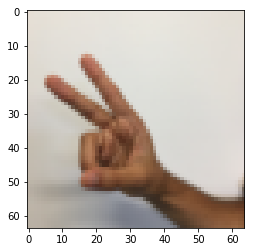

In [44]:
X_train_orig , Y_train_orig , X_test_orig , Y_test_orig , classes = cnn_utils.load_dataset()
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [45]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = cnn_utils.convert_to_one_hot(Y_train_orig, 6).T
Y_test = cnn_utils.convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


### 创建placeholders

In [46]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    为session创建占位符

    参数：
        n_H0 - 实数，输入图像的高度
        n_W0 - 实数，输入图像的宽度
        n_C0 - 实数，输入的通道数
        n_y  - 实数，分类数

    输出：
        X - 输入数据的占位符，维度为[None, n_H0, n_W0, n_C0]，类型为"float"
        Y - 输入数据的标签的占位符，维度为[None, n_y]，维度为"float"
    """
    X = tf.placeholder(tf.float32,[None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32,[None, n_y])

    return X,Y

### 初始化参数

In [47]:
def initialize_parameters():
    """
    初始化权值矩阵，这里我们把权值矩阵硬编码：
    W1 : [4, 4, 3, 8]
    W2 : [2, 2, 8, 16]

    返回：
        包含了tensor类型的W1、W2的字典
    """
    tf.set_random_seed(1)

    W1 = tf.get_variable("W1",[4,4,3,8],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2",[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed=0))

    parameters = {"W1": W1,
                  "W2": W2}

    return parameters

### 前向传播
在TensorFlow里面有一些可以直接拿来用的函数：
- **tf.nn.conv2d(X,W1,strides=[1,s,s,1],padding='SAME'):**给定输入 $X$和一组过滤器$W1$，这个函数将会自动使用$W1$来对 $X$进行卷积，第三个输入参数是[1,s,s,1]是指对于输入 (m, n_H_prev, n_W_prev, n_C_prev)而言，每次滑动的步伐。
- **tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'):**给定输入$X$，该函数将会使用大小为（f,f）以及步伐为(s,s)的窗口对其进行滑动取最大值.
- **tf.nn.relu(Z1):**计算$Z1$的ReLU激活
- **tf.contrib.layers.flatten(P):**给定一个输入P，此函数将会把每个样本转化成一维的向量，然后返回一个tensor变量，其维度为（batch_size,k）
- **tf.contrib.layers.fully_connected(F, num_outputs):**给定一个已经一维化了的输入F，此函数将会返回一个由全连接层计算过后的输出.使用tf.contrib.layers.fully_connected(F, num_outputs)的时候，全连接层会自动初始化权值且在你训练模型的时候它也会一直参与，所以当我们初始化参数的时候我们不需要专门去初始化它的权值。

我们实现前向传播的时候，我们需要定义一下我们模型的大概样子: `CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED`. 
我们具体实现的时候，我们需要使用以下的步骤和参数：

- Conv2d : 步伐：1，填充方式：“SAME”
- ReLU
- Max pool : 过滤器大小：8x8，步伐：8x8，填充方式：“SAME”
- Conv2d : 步伐：1，填充方式：“SAME”
- ReLU
- Max pool : 过滤器大小：4x4，步伐：4x4，填充方式：“SAME”
- 一维化上一层的输出
- 全连接层（FC）：使用没有非线性激活函数的全连接层。这里不要调用SoftMax， 这将导致输出层中有6个神经元，然后再传递到softmax。 在TensorFlow中，softmax和cost函数被集中到一个函数中，在计算成本时您将调用不同的函数。

In [48]:
def forward_propagation(X,parameters):
    """
    实现前向传播
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    参数：
        X - 输入数据的placeholder，维度为(输入节点数量，样本数量)
        parameters - 包含了“W1”和“W2”的python字典。

    返回：
        Z3 - 最后一个LINEAR节点的输出

    """
    W1 = parameters['W1']
    W2 = parameters['W2']

    #Conv2d : 步伐：1，填充方式：“SAME”
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding="SAME")
    #ReLU ：
    A1 = tf.nn.relu(Z1)
    #Max pool : 窗口大小：8x8，步伐：8x8，填充方式：“SAME”
    P1 = tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding="SAME")

    #Conv2d : 步伐：1，填充方式：“SAME”
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding="SAME")
    #ReLU ：
    A2 = tf.nn.relu(Z2)
    #Max pool : 过滤器大小：4x4，步伐：4x4，填充方式：“SAME”
    P2 = tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=[1,4,4,1],padding="SAME")

    #一维化上一层的输出
    P = tf.contrib.layers.flatten(P2)

    #全连接层（FC）：使用没有非线性激活函数的全连接层
    Z3 = tf.contrib.layers.fully_connected(P,6,activation_fn=None)

    return Z3

In [49]:
tf.reset_default_graph()
np.random.seed(1)

with tf.Session() as sess_test:
    X,Y = create_placeholders(64,64,3,6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)

    init = tf.global_variables_initializer()
    sess_test.run(init)

    a = sess_test.run(Z3,{X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = " + str(a))

    sess_test.close()


Z3 = [[ 1.4416984  -0.24909666  5.450499   -0.2618962  -0.20669907  1.3654671 ]
 [ 1.4070846  -0.02573211  5.08928    -0.48669922 -0.40940708  1.2624859 ]]


### 计算成本
- **tf.nn.softmax_cross_entropy_with_logits(logits = Z3 , lables = Y):**计算softmax的损失函数。这个函数既计算softmax的激活，也计算其损失
- **tf.reduce_mean：**计算的是平均值，使用它来计算所有样本的损失来得到总成本

In [50]:
def compute_cost(Z3,Y):
    """
    计算成本
    参数：
        Z3 - 正向传播最后一个LINEAR节点的输出，维度为（6，样本数）。
        Y - 标签向量的placeholder，和Z3的维度相同

    返回：
        cost - 计算后的成本

    """

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))

    return cost

### 构建模型

In [51]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.005, 
         num_epochs=100,minibatch_size=64,print_cost=True,isPlot=True):
    """
    使用TensorFlow实现三层的卷积神经网络
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    参数：
        X_train - 训练数据，维度为(None, 64, 64, 3)
        Y_train - 训练数据对应的标签，维度为(None, n_y = 6)
        X_test - 测试数据，维度为(None, 64, 64, 3)
        Y_test - 训练数据对应的标签，维度为(None, n_y = 6)
        learning_rate - 学习率
        num_epochs - 遍历整个数据集的次数
        minibatch_size - 每个小批量数据块的大小
        print_cost - 是否打印成本值，每遍历100次整个数据集打印一次
        isPlot - 是否绘制图谱

    返回：
        train_accuracy - 实数，训练集的准确度
        test_accuracy - 实数，测试集的准确度
        parameters - 学习后的参数
    """
    ops.reset_default_graph()  #能够重新运行模型而不覆盖tf变量
    tf.set_random_seed(1)    #确保你的数据和我一样
    seed = 3                 #指定numpy的随机种子
    (m , n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []

    #为当前维度创建占位符
    X , Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    #初始化参数
    parameters = initialize_parameters()

    #前向传播
    Z3 = forward_propagation(X,parameters)

    #计算成本
    cost = compute_cost(Z3,Y)

    #反向传播，由于框架已经实现了反向传播，我们只需要选择一个优化器就行了
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    #全局初始化所有变量
    init = tf.global_variables_initializer()

    #开始运行
    with tf.Session() as sess:
        #初始化参数
        sess.run(init)
        #开始遍历数据集
        for epoch in range(num_epochs):
            minibatch_cost = 0
            num_minibatches = int(m / minibatch_size) #获取数据块的数量
            seed = seed + 1
            minibatches = cnn_utils.random_mini_batches(X_train,Y_train,minibatch_size,seed) 

            #对每个数据块进行处理
            for minibatch in minibatches:
                #选择一个数据块
                (minibatch_X,minibatch_Y) = minibatch
                #最小化这个数据块的成本
                _ , temp_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X, Y:minibatch_Y})

                #累加数据块的成本值
                minibatch_cost += temp_cost / num_minibatches

            #是否打印成本
            if print_cost:
                #每5代打印一次
                if epoch % 5 == 0:
                    print("当前是第 " + str(epoch) + " 代，成本值为：" + str(minibatch_cost))

            #记录成本
            if epoch % 1 == 0:
                costs.append(minibatch_cost)

        #数据处理完毕，绘制成本曲线
        if isPlot:
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations (per tens)')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()

        #开始预测数据
        ## 计算当前的预测情况
        predict_op = tf.arg_max(Z3,1)
        corrent_prediction = tf.equal(predict_op , tf.arg_max(Y,1))

        ##计算准确度
        accuracy = tf.reduce_mean(tf.cast(corrent_prediction,"float"))
        print("corrent_prediction accuracy= " + str(accuracy))

        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuary = accuracy.eval({X: X_test, Y: Y_test})

        print("训练集准确度：" + str(train_accuracy))
        print("测试集准确度：" + str(test_accuary))

        return (train_accuracy,test_accuary,parameters)

当前是第 0 代，成本值为：1.9278876781463623
当前是第 5 代，成本值为：1.8545504584908485
当前是第 10 代，成本值为：1.4376233145594597
当前是第 15 代，成本值为：1.174662847071886
当前是第 20 代，成本值为：0.8653046526014805
当前是第 25 代，成本值为：0.6780867427587509
当前是第 30 代，成本值为：0.5447503589093685
当前是第 35 代，成本值为：0.49181411229074
当前是第 40 代，成本值为：0.4001705963164568
当前是第 45 代，成本值为：0.35277092084288597
当前是第 50 代，成本值为：0.32860616967082024
当前是第 55 代，成本值为：0.29591358732432127
当前是第 60 代，成本值为：0.2493568081408739
当前是第 65 代，成本值为：0.2553568286821246
当前是第 70 代，成本值为：0.23998444434255362
当前是第 75 代，成本值为：0.19640650693327188
当前是第 80 代，成本值为：0.20804784074425697
当前是第 85 代，成本值为：0.20917906798422337
当前是第 90 代，成本值为：0.1500953882932663
当前是第 95 代，成本值为：0.1464792932383716
当前是第 100 代，成本值为：0.15142427338287234
当前是第 105 代，成本值为：0.11644003028050065
当前是第 110 代，成本值为：0.17207090696319938
当前是第 115 代，成本值为：0.10988676245324314
当前是第 120 代，成本值为：0.11329394578933716
当前是第 125 代，成本值为：0.1189448619261384
当前是第 130 代，成本值为：0.08451234316453338
当前是第 135 代，成本值为：0.06741330120712519
当前是第 140 代，成本值为：0.0846093075815

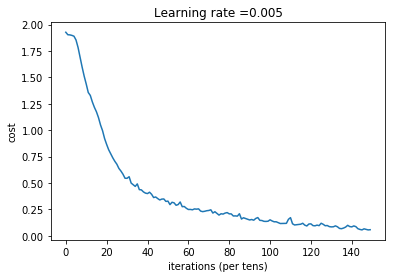

Instructions for updating:
Use `tf.math.argmax` instead
corrent_prediction accuracy= Tensor("Mean_1:0", shape=(), dtype=float32)
训练集准确度：0.99444443
测试集准确度：0.8833333


In [52]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test,num_epochs=150)

In [ ]:
keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)

In [ ]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

model = Sequential()
# 输入: 3 通道 100x100 像素图像 -> (100, 100, 3) 张量。
# 使用 32 个大小为 3x3 的卷积滤波器。
model.add(Conv2D(32, (4, 4), activation='relu',padding='same', input_shape=(64, 64, 3)))
#model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(8, 8),strides=(8, 8)))
#model.add(Dropout(0.25))

model.add(Conv2D(64, (4, 4), activation='relu'))
#model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4),strides=(4, 4)))
#model.add(Dropout(0.25))

model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=64, epochs=150)

Epoch 1/150
1080/1080 [==============================] - 6s 6ms/step - loss: 1.8079 - acc: 0.1704
Epoch 2/150
1080/1080 [==============================] - 5s 5ms/step - loss: 1.7461 - acc: 0.2398
Epoch 3/150
1080/1080 [==============================] - 5s 5ms/step - loss: 1.6742 - acc: 0.3759
Epoch 4/150
1080/1080 [==============================] - 5s 5ms/step - loss: 1.5672 - acc: 0.4870
Epoch 5/150
1080/1080 [==============================] - 5s 5ms/step - loss: 1.4269 - acc: 0.5611
Epoch 6/150
1080/1080 [==============================] - 5s 5ms/step - loss: 1.2796 - acc: 0.6213
Epoch 7/150
1080/1080 [==============================] - 5s 5ms/step - loss: 1.1332 - acc: 0.6880
Epoch 8/150
1080/1080 [==============================] - 5s 5ms/step - loss: 1.0359 - acc: 0.6602
Epoch 9/150
1080/1080 [==============================] - 6s 5ms/step - loss: 0.9411 - acc: 0.6972
Epoch 10/150
1080/1080 [==============================] - 5s 5ms/step - loss: 0.8655 - acc: 0.7269
Epoch 11/150
1080/1

In [ ]:
score = model.evaluate(X_test, Y_test, batch_size=128)